In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path
from qhchina.helpers import load_fonts
load_fonts()

def visualize_sequence_perplexity(text_id, 
                                  start_idx, 
                                  end_idx, 
                                  start_rgb, 
                                  end_rgb, 
                                  width_inches,
                                  savefig_path=None):
    """
    Visualize perplexity data for a sequence across multiple epochs.
    
    Args:
        text_id: Text document ID to analyze
        start_idx: Start index for sequence (inclusive)
        end_idx: End index for sequence (inclusive)
        start_rgb: RGB tuple for start color (r, g, b)
        end_rgb: RGB tuple for end color (r, g, b)
        width_inches: Width of the figure in inches
    """
    
    # Load epoch JSON files
    epoch_data = {}
    
    # You need to update this path to point to your epoch JSON files directory
    epoch_files_directory = "../results/case_studies"
    
    # Look for epoch files in the directory
    epoch_files = list(Path(epoch_files_directory).glob("epoch_*_perplexities.json"))
    
    for epoch_file in epoch_files:
        # Extract epoch number from filename
        match = re.search(r'epoch_(-?\d+)_perplexities', epoch_file.name)
        if match:
            epoch_num = int(match.group(1))
            
            # Load the JSON file
            with open(epoch_file, 'r') as f:
                content = json.load(f)
            
            # Convert to easier lookup format
            epoch_dict = {}
            for doc in content:
                if 'text_id' not in doc or 'token_data' not in doc:
                    continue
                
                doc_text_id = doc['text_id']
                
                # Extract data from token_data tuples (token, token_id, perplexity)
                tokens = []
                perplexities = []
                for token_data in doc['token_data']:
                    if len(token_data) >= 3:
                        token, token_id, perplexity = token_data[:3]
                        tokens.append(token)
                        perplexities.append(perplexity)
                
                epoch_dict[doc_text_id] = {
                    'text': doc.get('text', ''),
                    'tokens': tokens,
                    'perplexities': perplexities
                }
            
            epoch_data[epoch_num] = epoch_dict
    
    # Extract sequence data for each epoch
    available_epochs = sorted(epoch_data.keys())
    epoch_perplexities = {}
    sequence_tokens = None
    
    for epoch in available_epochs:
        if text_id not in epoch_data[epoch]:
            print(f"Warning: Text ID '{text_id}' not found in epoch {epoch}")
            continue
        
        text_data = epoch_data[epoch][text_id]
        
        # Validate range (end_idx is inclusive)
        if end_idx >= len(text_data['tokens']):
            print(f"Warning: End index {end_idx} exceeds document length {len(text_data['tokens'])-1} in epoch {epoch}")
            continue
        
        # Extract sequence perplexities (end_idx is inclusive)
        sequence_perps = text_data['perplexities'][start_idx:end_idx+1]
        epoch_perplexities[epoch] = sequence_perps
        
        # Get tokens (should be same across epochs, end_idx is inclusive)
        if sequence_tokens is None:
            sequence_tokens = text_data['tokens'][start_idx:end_idx+1]
    
    # Color gradient function
    def generate_color_gradient(n_colors, start_rgb, end_rgb):
        if n_colors <= 1:
            return [start_rgb]
        colors = []
        for i in range(n_colors):
            ratio = i / (n_colors - 1)
            r = start_rgb[0] + (end_rgb[0] - start_rgb[0]) * ratio
            g = start_rgb[1] + (end_rgb[1] - start_rgb[1]) * ratio
            b = start_rgb[2] + (end_rgb[2] - start_rgb[2]) * ratio
            colors.append((r, g, b))
        return colors

    # Format epoch names
    def format_epoch_name(epoch_num):
        if epoch_num == -1:
            return "Base"
        else:
            return f"Epoch {epoch_num + 1}"

    # Create the plot
    fig, ax = plt.subplots(figsize=(width_inches, 4.8), dpi=300)

    # Generate colors
    colors = generate_color_gradient(len(available_epochs), start_rgb, end_rgb)

    # Plot each epoch
    for i, epoch_num in enumerate(available_epochs):
        if epoch_num in epoch_perplexities:
            perplexities = epoch_perplexities[epoch_num]
            x_positions = list(range(len(perplexities)))
            ax.plot(x_positions, perplexities, 
                   color=colors[i], linewidth=2, marker='o', markersize=3.8,
                   alpha=0.49, label=format_epoch_name(epoch_num))

    # Set up axes
    data_length = len(sequence_tokens) if sequence_tokens else 0
    x_range = [-1, data_length]
    ax.set_xlim(x_range)
    ax.set_xlabel("Character Sequence", fontsize=14, fontweight='bold')

    # Set x-axis ticks to show tokens
    if sequence_tokens:
        ax.set_xticks(list(range(data_length)))
        ax.set_xticklabels(sequence_tokens, rotation=0, fontsize=12)

    # Secondary x-axis for token positions
    ax2 = ax.twiny()
    if data_length > 0:
        token_labels = [1] + [5 * i for i in range(1, (data_length // 5) + 2) if 5 * i <= data_length]
        token_tick_vals = [label - 1 for label in token_labels if label - 1 < data_length]
        token_tick_labels = [str(label) for label in token_labels if label - 1 < data_length]
    else:
        token_tick_vals = [0, 4, 9, 14, 19]
        token_tick_labels = ["1", "5", "10", "15", "20"]

    ax2.set_xlim(x_range)
    ax2.set_xticks(token_tick_vals)
    ax2.set_xticklabels(token_tick_labels, fontsize=12)
    ax2.set_xlabel("Token Position", fontsize=14, fontweight='bold')

    # Y-axis setup
    all_perps = []
    for perps in epoch_perplexities.values():
        all_perps.extend(perps)

    if all_perps:
        ax.set_yscale('log')
        ax.set_ylabel("Perplexity (Log Scale)", fontsize=14, fontweight='bold')
        if min(all_perps) > 0 and max(all_perps) > 0:
            y_min = min(all_perps)
            y_max = max(all_perps) * 3
            ax.set_ylim([y_min, y_max])
    else:
        ax.set_ylabel("Perplexity", fontsize=14, fontweight='bold')
        if all_perps and min(all_perps) >= 0:
            y_min = min(all_perps)
            y_max = max(all_perps) * 1.2
            ax.set_ylim([y_min, y_max])

    # Grid and legend
    ax.grid(True, alpha=0.30, linewidth=1)
    legend = ax.legend(loc='upper right', 
                      fontsize=12, frameon=True, facecolor="white", 
                      edgecolor="black", framealpha=0.7)

    if legend.get_frame():
        legend.get_frame().set_linewidth(1)

    plt.tight_layout(pad=2.0)

    # Background color
    face_color = 'white'
    bg_color_setting = 'White'
    if bg_color_setting == "Light Gray":
        face_color = '#f8f9fa'
    elif bg_color_setting == "Transparent":
        face_color = 'none'

    # Save or show the plot
    if savefig_path is not None:
        plt.savefig(savefig_path, format='png', dpi=300, 
                    bbox_inches='tight', facecolor=face_color, edgecolor='none', pad_inches=0.3)
    plt.show()

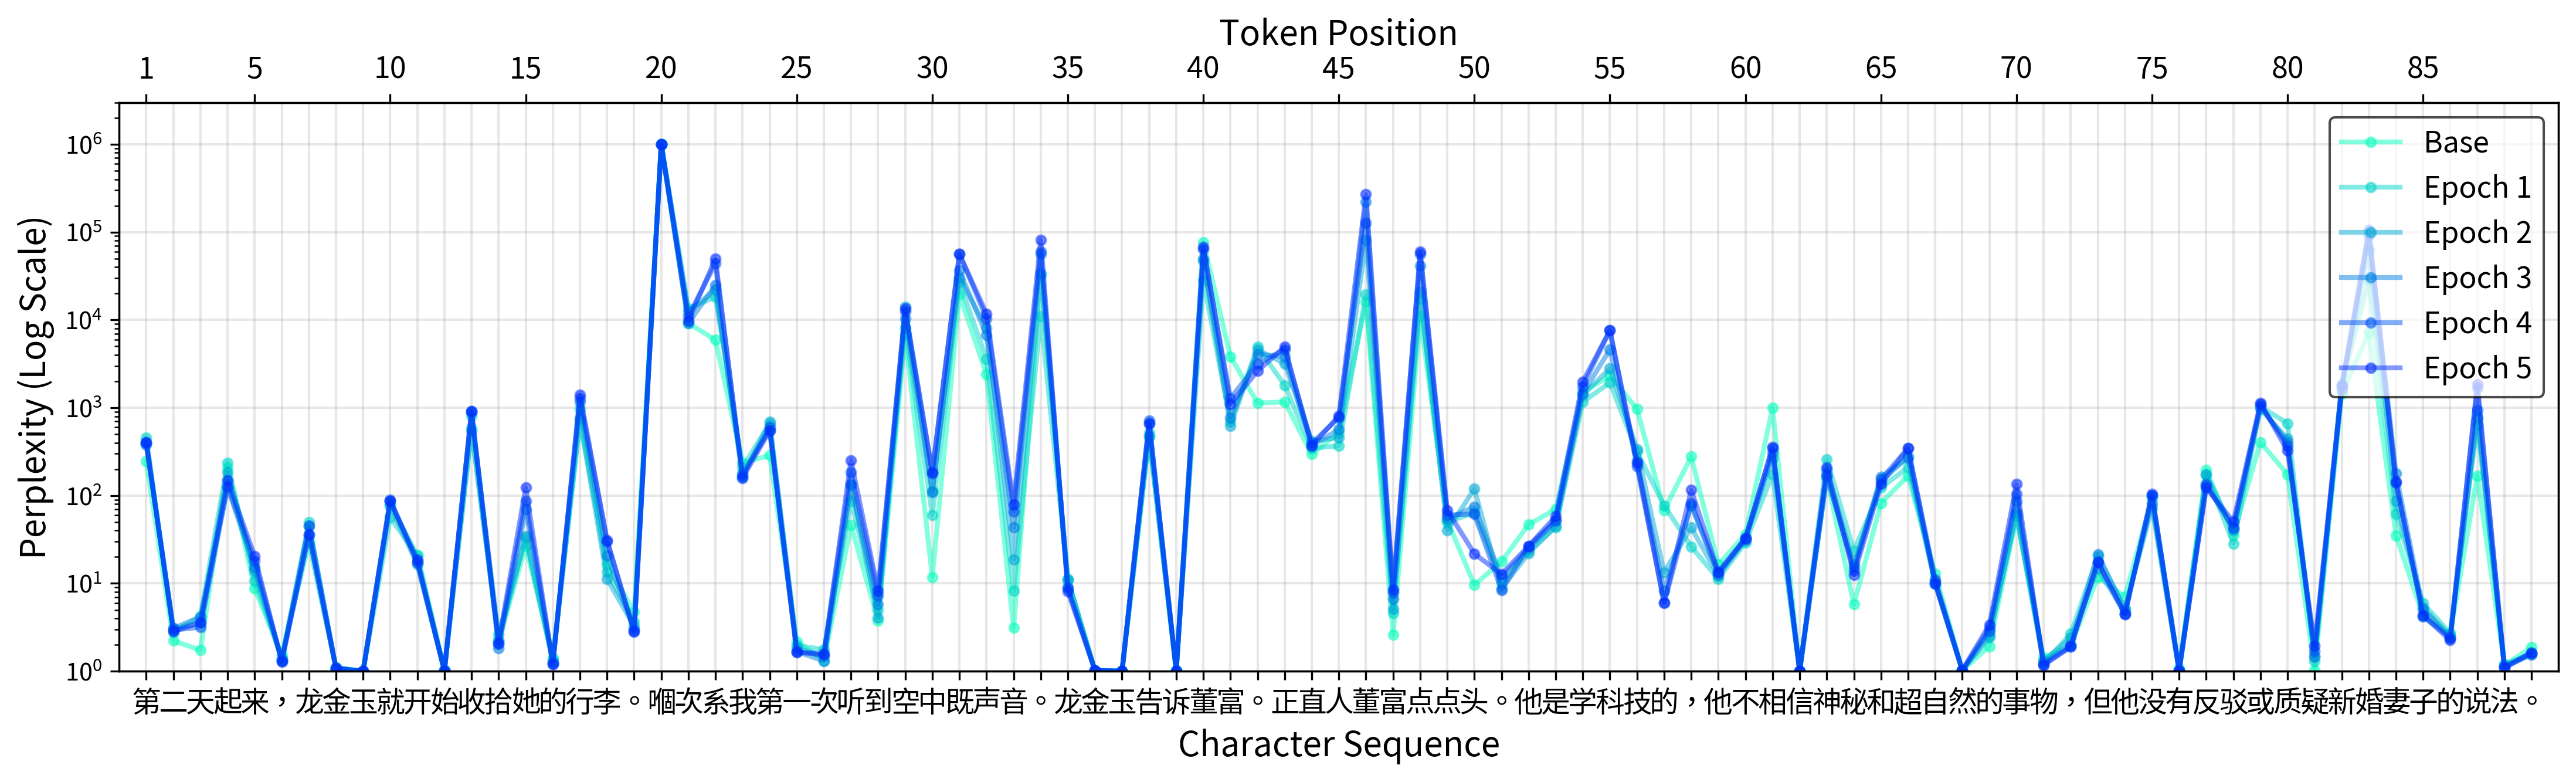

In [18]:
text_id = 'chunk_0'
start_idx = 440
end_idx = 528
start_rgb = (0.000, 1.000, 0.741)
end_rgb = (0.000, 0.169, 1.000)
width_inches = 15.0

visualize_sequence_perplexity(text_id, start_idx, end_idx, start_rgb, end_rgb, width_inches, savefig_path="png/casestudy_dungkaicheung.png")

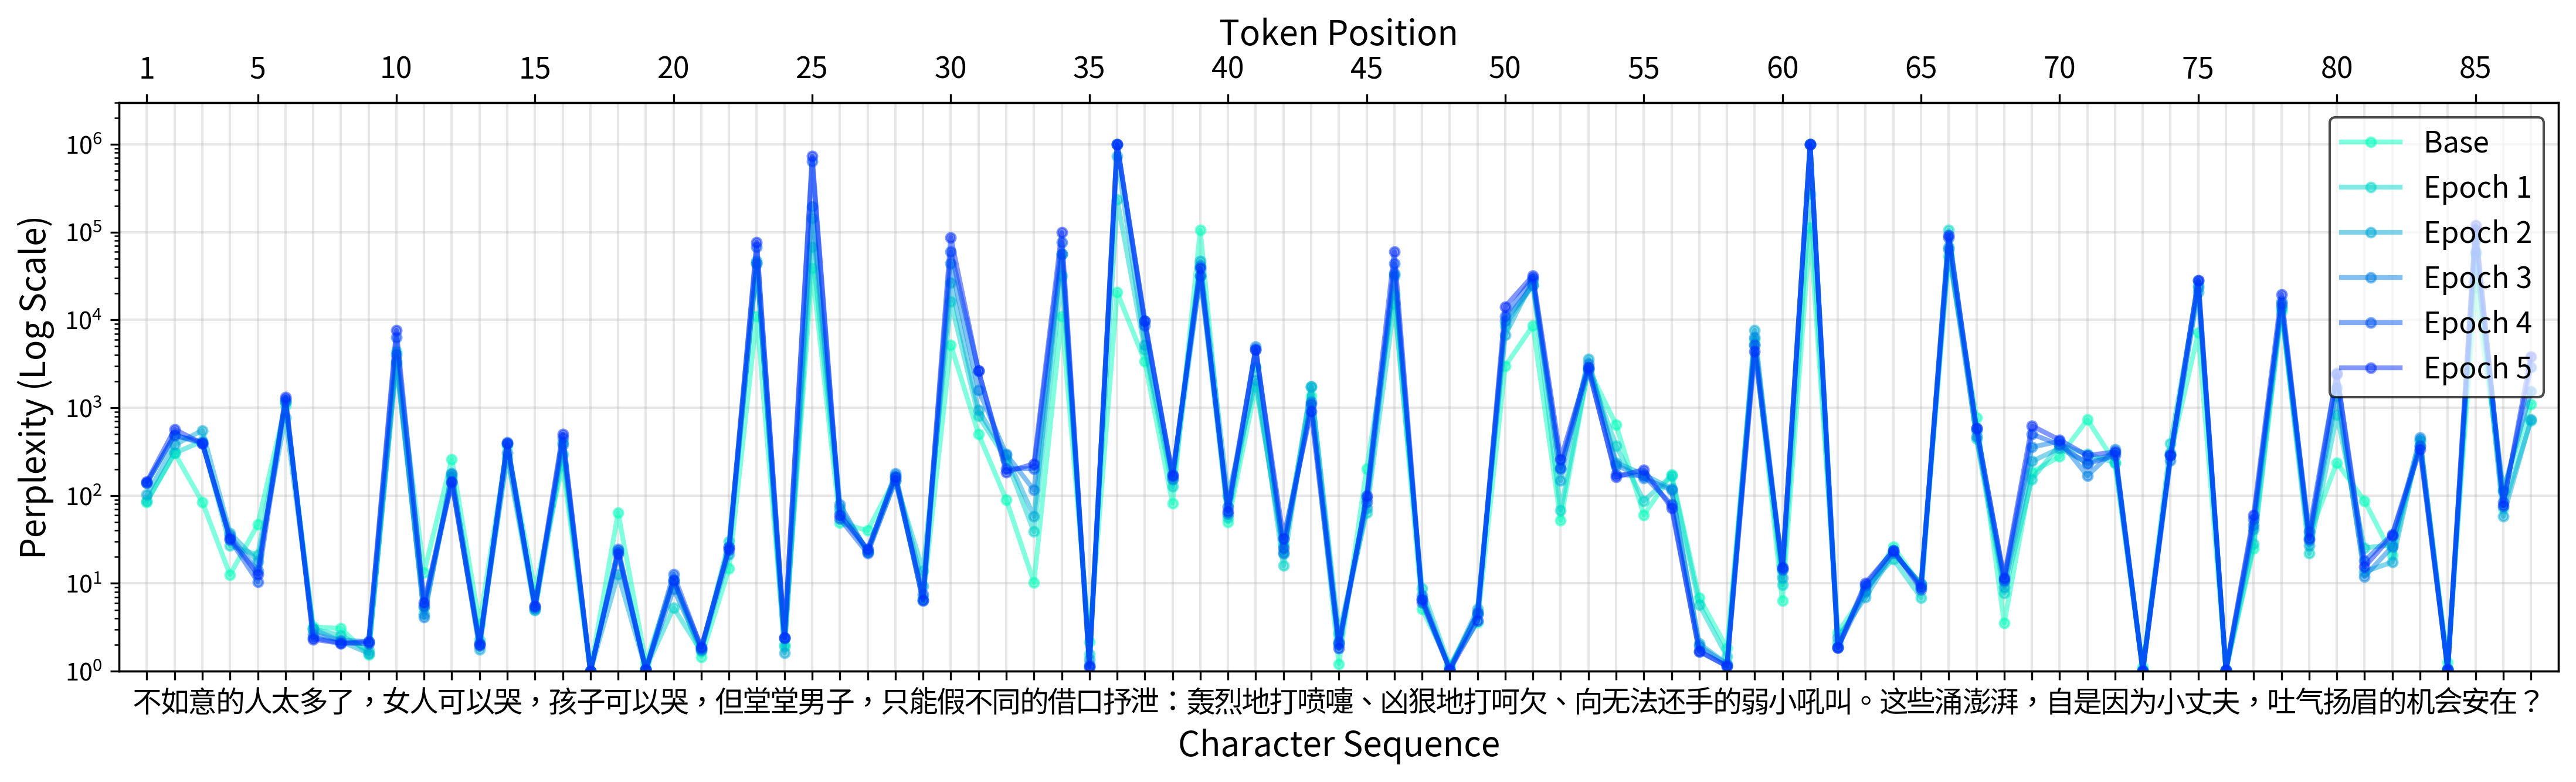

In [ ]:
text_id = 'chunk_1'
start_idx = 388
end_idx = 474
start_rgb = (0.000, 1.000, 0.741)
end_rgb = (0.000, 0.169, 1.000)
width_inches = 15.0

visualize_sequence_perplexity(text_id, start_idx, end_idx, start_rgb, end_rgb, width_inches, savefig_path="png/casestudy_lilianlee.png")

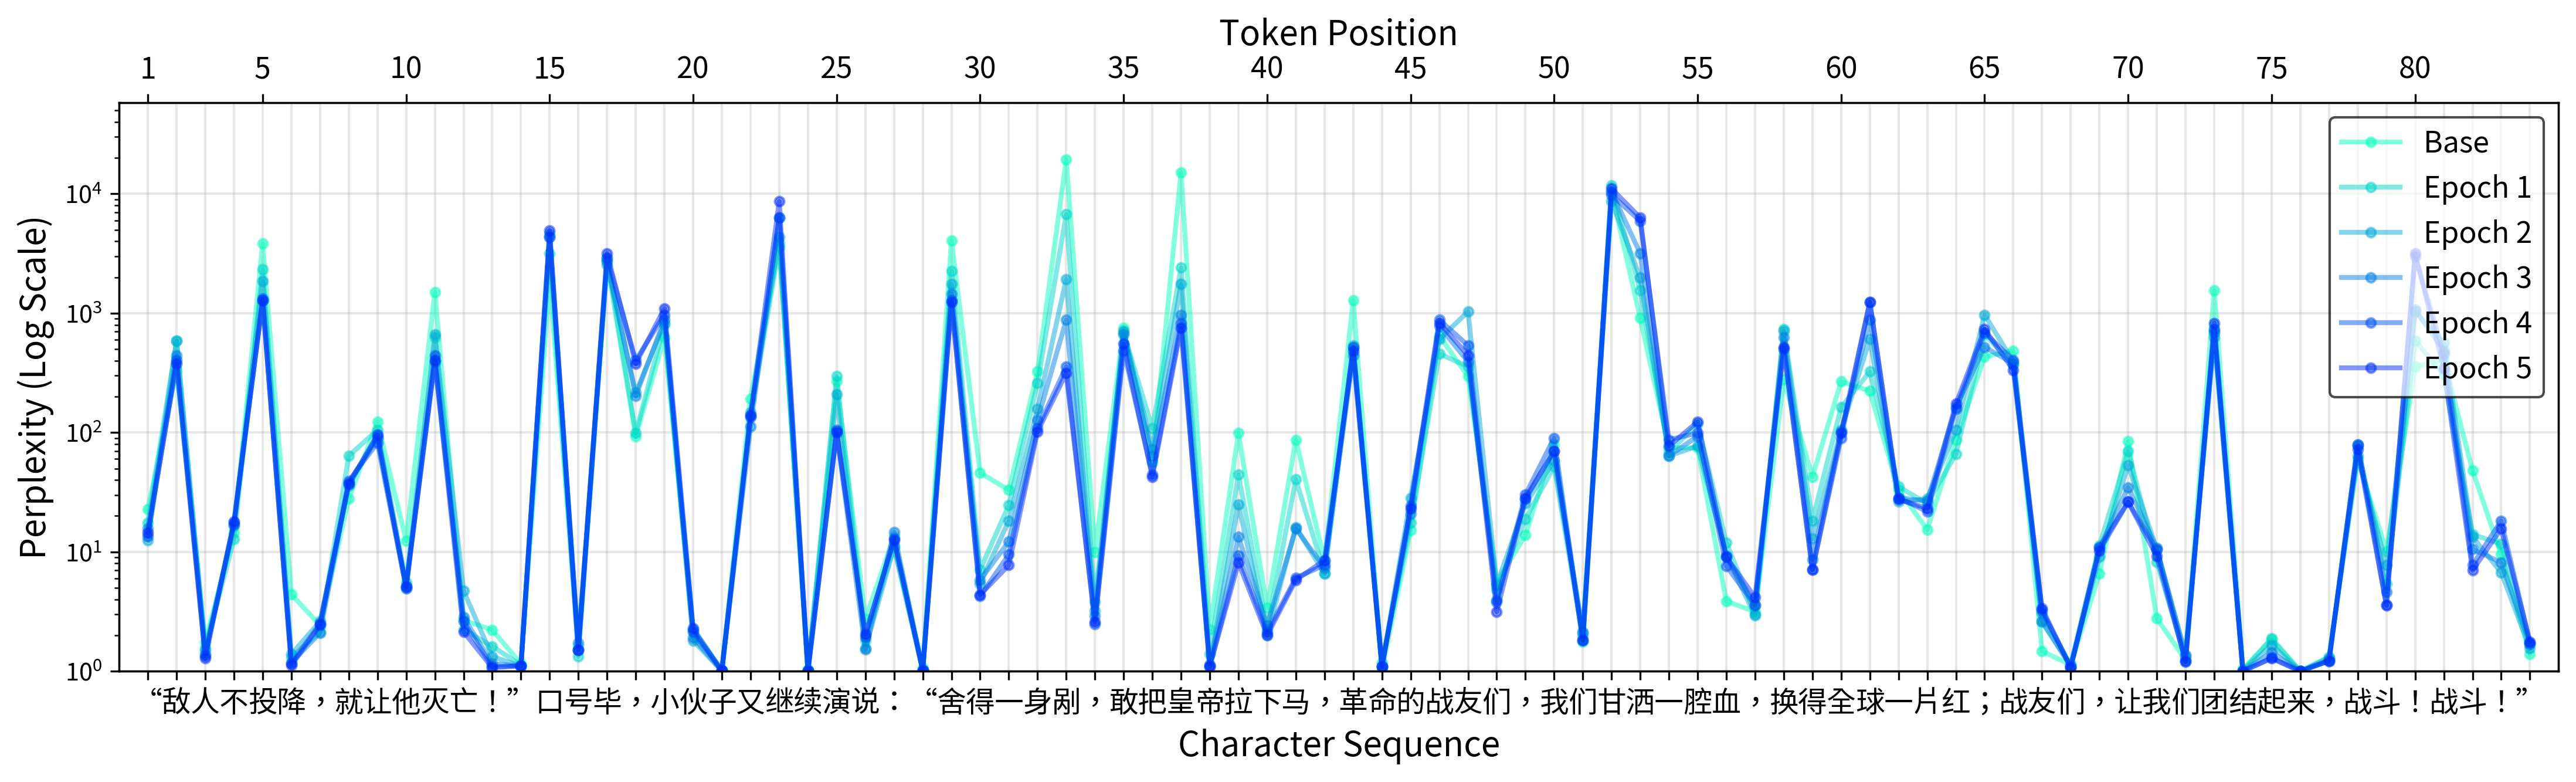

In [7]:
text_id = 'chunk_2'
start_idx = 583
end_idx = 666
start_rgb = (0.000, 1.000, 0.741)
end_rgb = (0.000, 0.169, 1.000)
width_inches = 15.0

visualize_sequence_perplexity(text_id, start_idx, end_idx, start_rgb, end_rgb, width_inches)